In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 24})
sns.set_style("darkgrid")

# EDA & Data Preprocessing
In this notebook, we're going to carry out a few EDA operations to get acquainted with the data set of the challenge. We will analyze the 7 features and their relationships, generate new derived features and justify the representativeness of a 10% subsample on the basis of faster subsequent training.

## Dataframes creation

In [2]:
df_x = pd.read_csv('../dataset/X_train.csv').drop(columns=['id'])
df_y = pd.read_csv('../dataset/y_train.csv').drop(columns=['id'])
df_y['trq_target'] = df_x['trq_measured'] / (df_y['trq_margin'] / 100 + 1)
df_x.describe()

,trq_measured,oat,mgt,pa,ias,np,ng
count,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000
mean,65.097549,12.675167,592.246116,511.776065,79.324591,97.377919,95.517281
std,13.253672,8.066084,39.654582,563.190555,35.395075,3.996721,3.635084
min,14.673340,-19.250000,467.300000,-208.389200,0.000000,85.010000,90.001830
25%,56.100000,7.500000,562.400000,135.331200,51.125000,95.330000,92.226440
50%,65.700000,13.703440,589.400000,340.461600,88.375000,99.759770,94.810000
75%,75.500000,18.500000,622.300000,588.264000,110.562500,100.020000,99.900000
max,104.730500,36.799130,723.400000,3097.510000,137.562500,101.560000,101.220000


## Explorative Data Analysis
### Skewness study

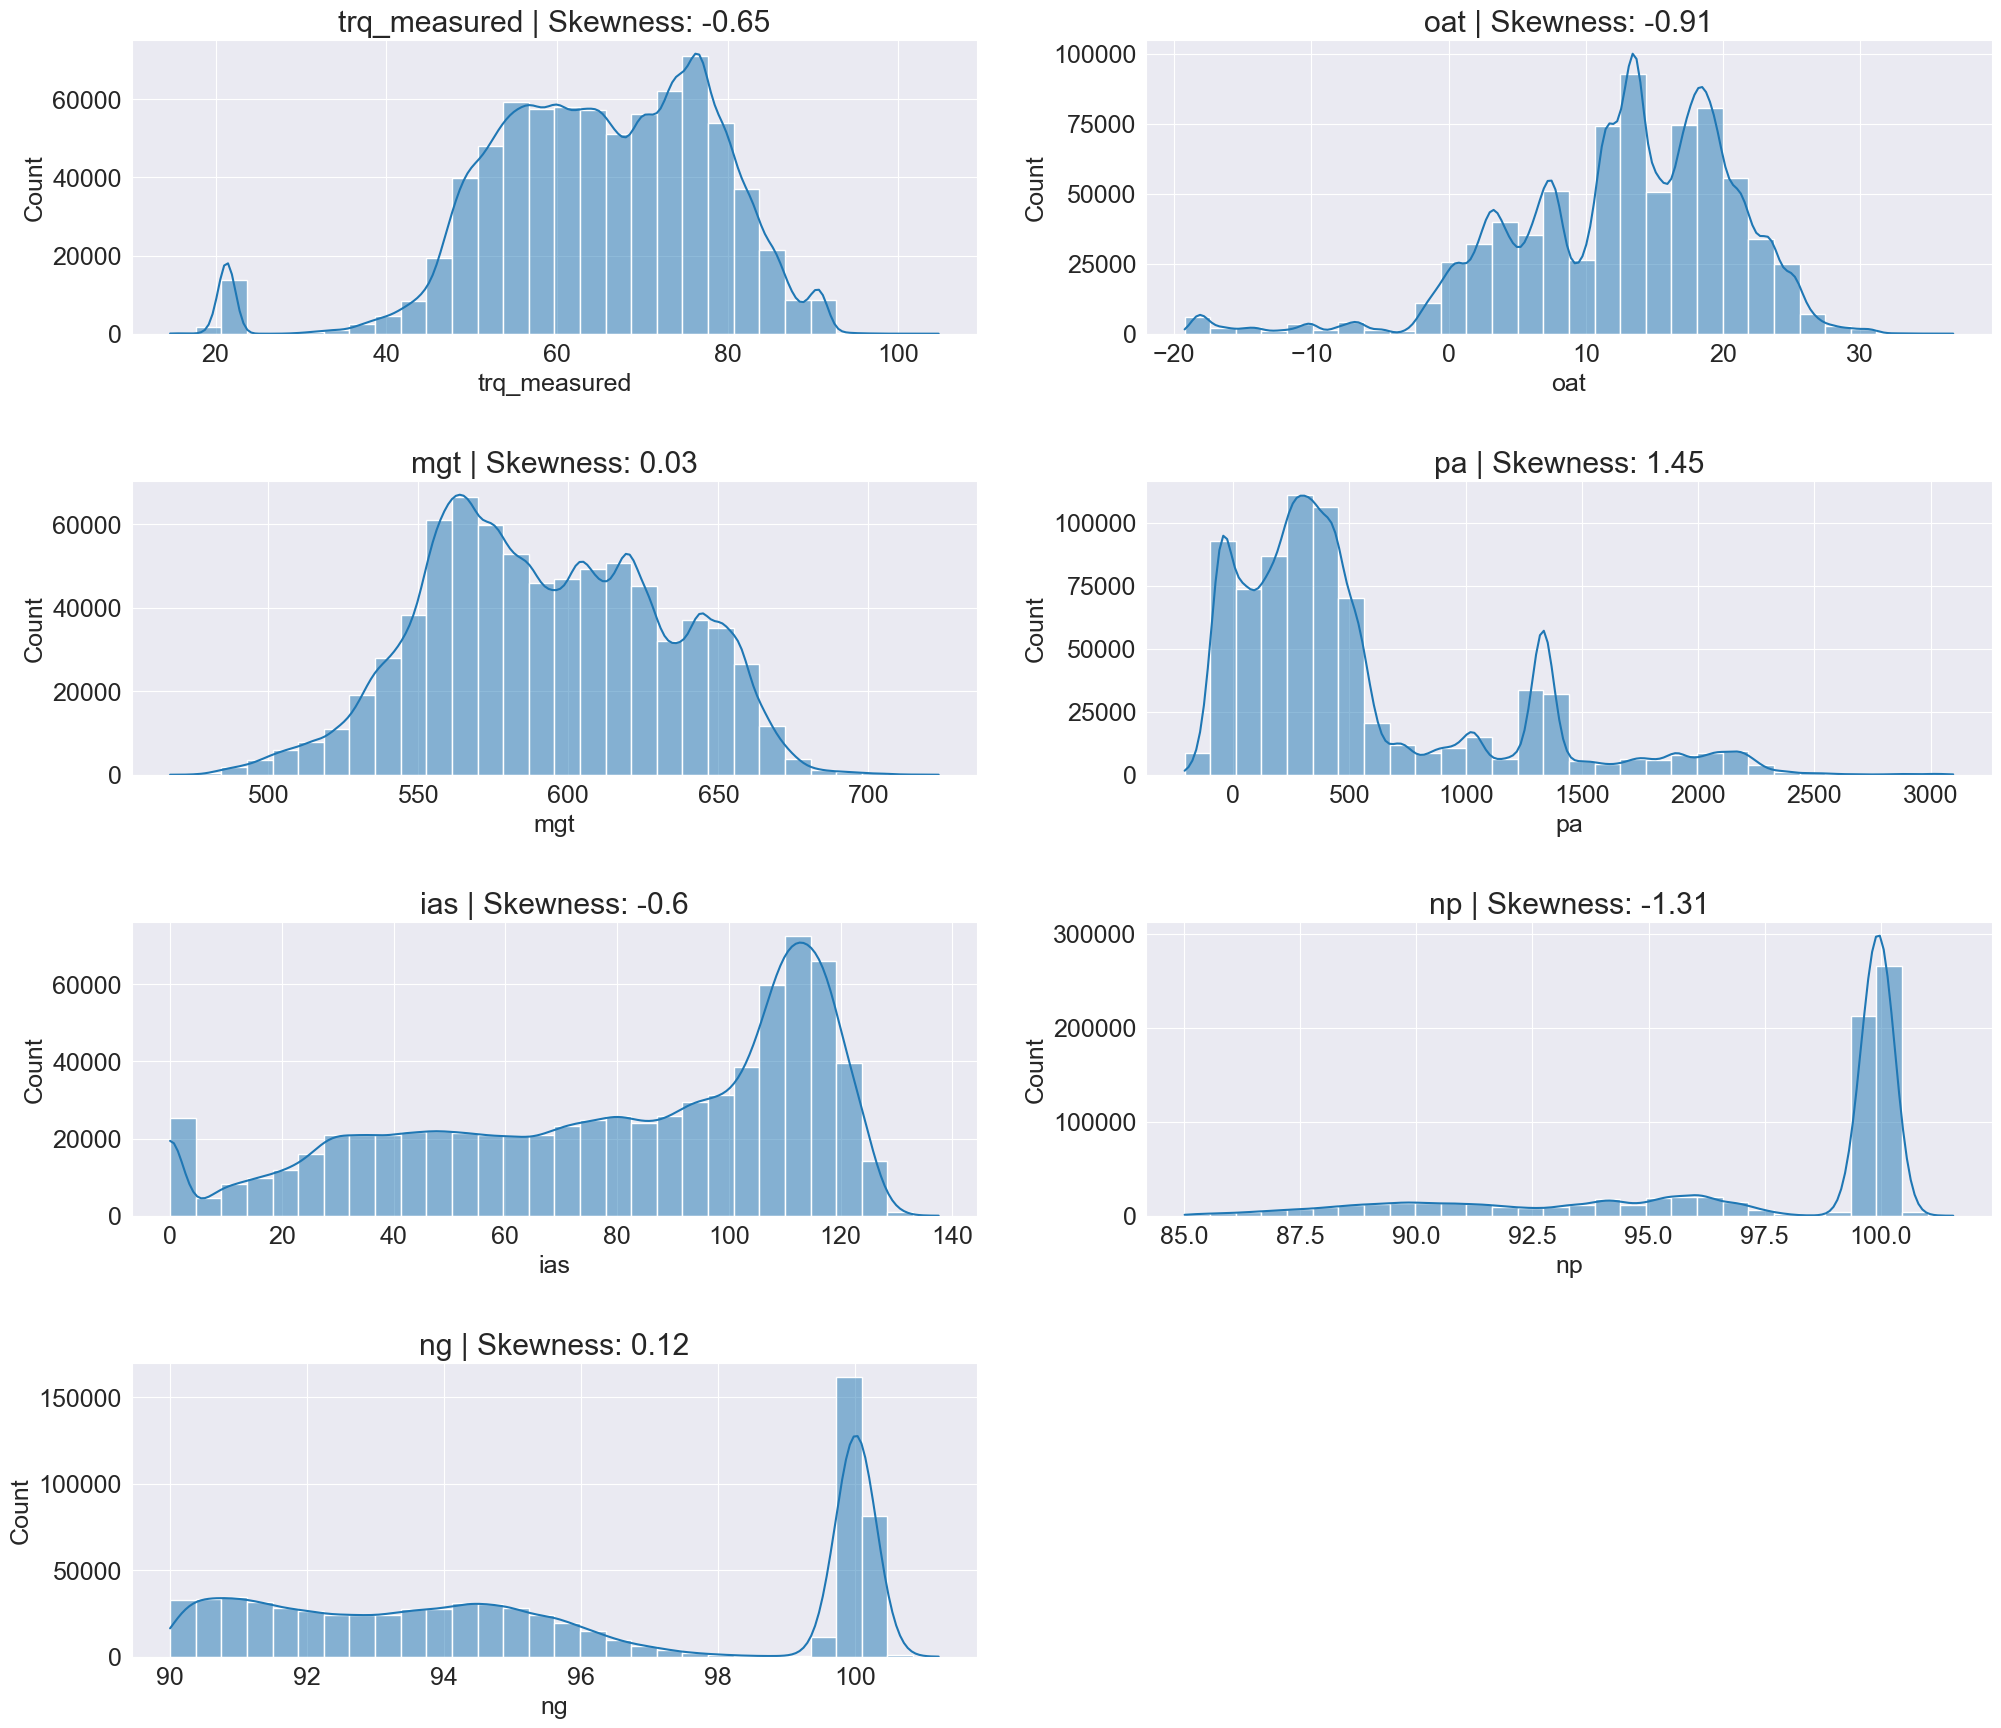

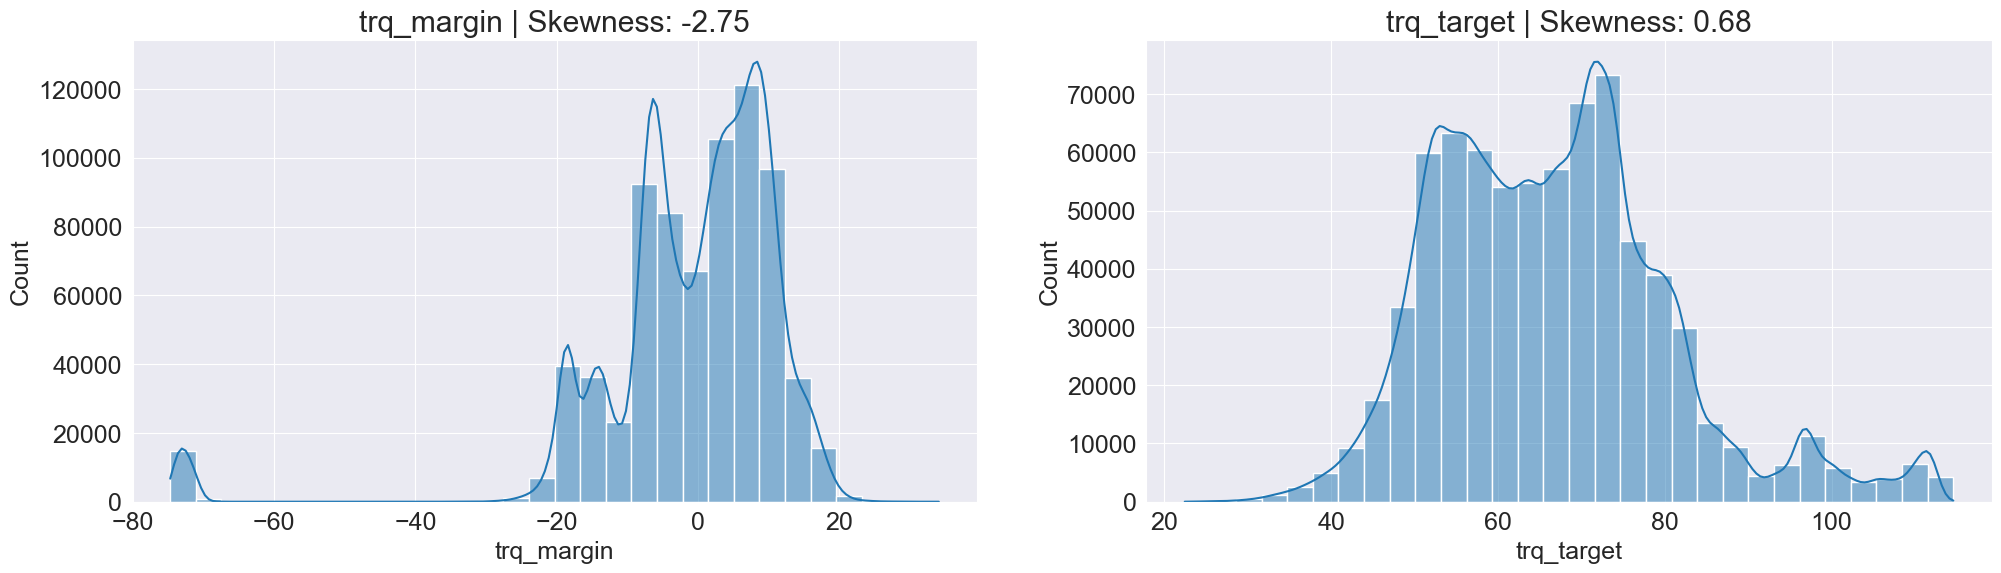

In [14]:
### PLOT FEATURES ###
num_x_features = len(df_x.columns)
plt.figure(figsize=(24, num_x_features * 3))
for idx, feature in enumerate(df_x.columns,1):
    plt.subplot((num_x_features + 1) // 2, 2, idx)
    sns.histplot(df_x[feature], kde=True, bins=30)
    plt.title(f"{feature} | Skewness: {round(df_x[feature].skew(), 2)}")

plt.subplots_adjust(hspace=0.5)

### PLOT Y_TRAIN FEATURES ###
num_y_features = 2
plt.figure(figsize=(24, num_y_features * 3))
for idx, feature in enumerate(['trq_margin','trq_target'], 1):
    plt.subplot((num_y_features + 1) // 2, 2, idx)
    sns.histplot(df_y[feature], kde=True, bins=30)
    plt.title(f"{feature} | Skewness: {round(df_y[feature].skew(), 2)}")

# plt.tight_layout()
plt.show()

The features in this dataset that have skewness – exactly 0 depicts the symmetrical distribution and the plots with skewness 1 or above 1 is positively or right skewd distribution. In right skewd or positively skewed distribution if the tail is more on the right side, that indicates extremely high values.

### Faulty distributions

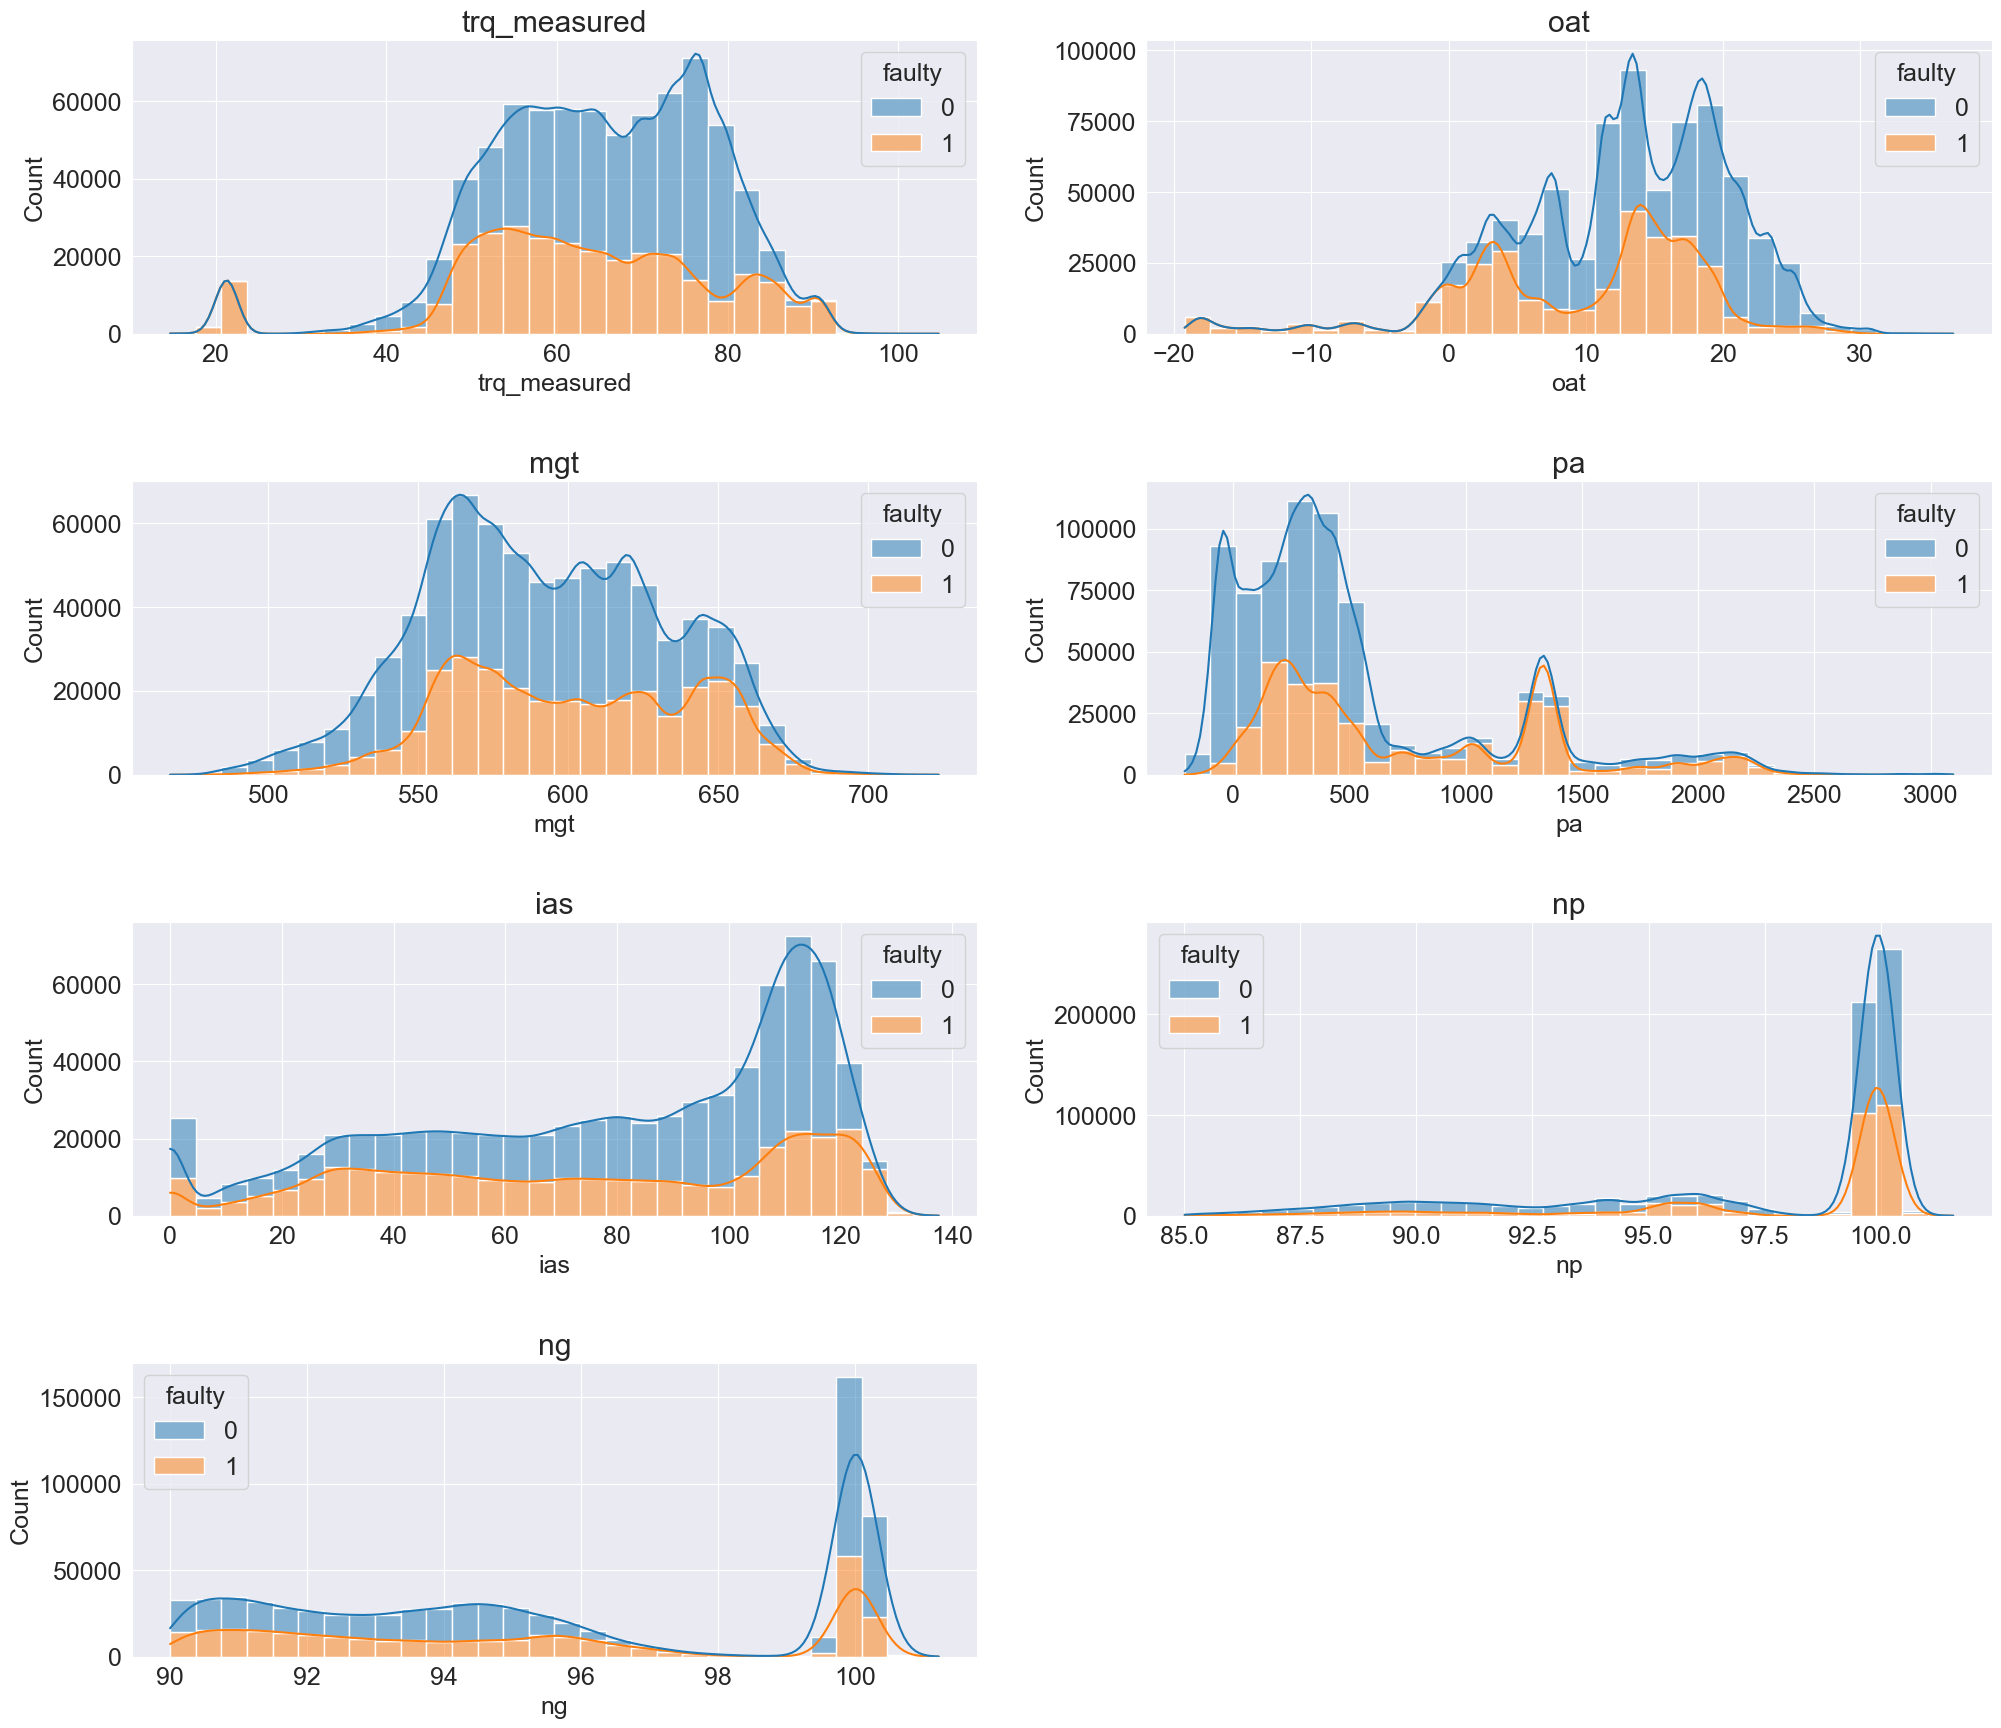

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

### PLOT FEATURES BY FAULTY CLASS LABEL ###
num_x_features = len(df_x.columns)
plt.figure(figsize=(24, num_x_features * 3))

for idx, feature in enumerate(df_x.columns, 1):
    plt.subplot((num_x_features + 1) // 2, 2, idx)
    sns.histplot(data=df_x, x=feature, hue=df_y["faulty"], kde=True, bins=30, palette="tab10", multiple="stack")
    plt.title(f"{feature}")

plt.subplots_adjust(hspace=0.5)
plt.show()


### Feature eptagram

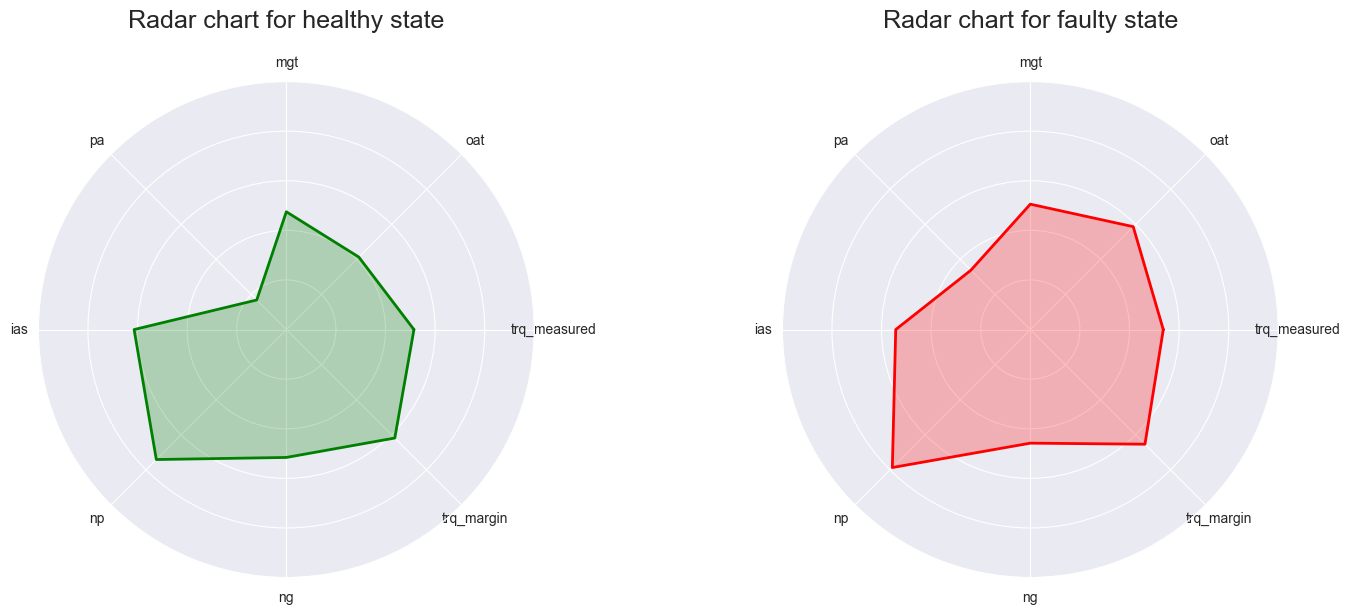

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. Merge df_x (features) and df_y (labels) if necessary
# ----------------------------------------------------------------------
train_data = pd.concat([df_x, df_y], axis=1)

# Remove the 'id' column if present
if 'id' in train_data.columns:
    train_data = train_data.drop(['id'], axis=1)

# ----------------------------------------------------------------------
# 2. Remove 'trq_target' from the dataset
# ----------------------------------------------------------------------
if 'trq_target' in train_data.columns:
    train_data = train_data.drop(['trq_target'], axis=1)

# ----------------------------------------------------------------------
# 3. Split data into healthy (faulty == 0) and faulty (faulty == 1) subsets
# ----------------------------------------------------------------------
X_train_healthy = train_data[train_data['faulty'] == 0].drop('faulty', axis=1)
X_train_faulty = train_data[train_data['faulty'] == 1].drop('faulty', axis=1)

# ----------------------------------------------------------------------
# 4. Min-Max scaling: Normalize all features between 0 and 1
# ----------------------------------------------------------------------
def min_max_scale(df):
    return (df - df.min()) / (df.max() - df.min())

X_train_healthy_scaled = min_max_scale(X_train_healthy)
X_train_faulty_scaled = min_max_scale(X_train_faulty)

# Compute the mean value of each feature for both groups
mean_features_healthy = X_train_healthy_scaled.mean()
mean_features_faulty = X_train_faulty_scaled.mean()

labels = mean_features_healthy.index
values_healthy = mean_features_healthy.values
values_faulty = mean_features_faulty.values

# ----------------------------------------------------------------------
# 5. Prepare data for radar charts
# ----------------------------------------------------------------------
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the loop for radar charts
values_healthy = np.concatenate((values_healthy, [values_healthy[0]]))
values_faulty = np.concatenate((values_faulty, [values_faulty[0]]))
angles += angles[:1]

# ----------------------------------------------------------------------
# 6. Adjust figure size dynamically based on the number of features
# ----------------------------------------------------------------------
fig_size = (min(2 * num_vars, 18), min(2 * num_vars, 9))
fig, axs = plt.subplots(1, 2, figsize=fig_size, subplot_kw=dict(polar=True))

# Radar chart for healthy state
axs[0].fill(angles, values_healthy, color='g', alpha=0.25)
axs[0].plot(angles, values_healthy, color='g', linewidth=2)
axs[0].set_yticklabels([])
axs[0].set_xticks(angles[:-1])
axs[0].set_xticklabels(labels, fontsize=10)
axs[0].set_title("Radar chart for healthy state", size=18, pad=20)
axs[0].set_ylim(0, 1)  # Keep scale between 0 and 1

# Radar chart for faulty state
axs[1].fill(angles, values_faulty, color='r', alpha=0.25)
axs[1].plot(angles, values_faulty, color='r', linewidth=2)
axs[1].set_yticklabels([])
axs[1].set_xticks(angles[:-1])
axs[1].set_xticklabels(labels, fontsize=10)
axs[1].set_title("Radar chart for faulty state", size=18, pad=20)
axs[1].set_ylim(0, 1)  # Keep scale between 0 and 1

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0.5)

plt.show()


### Correlation study

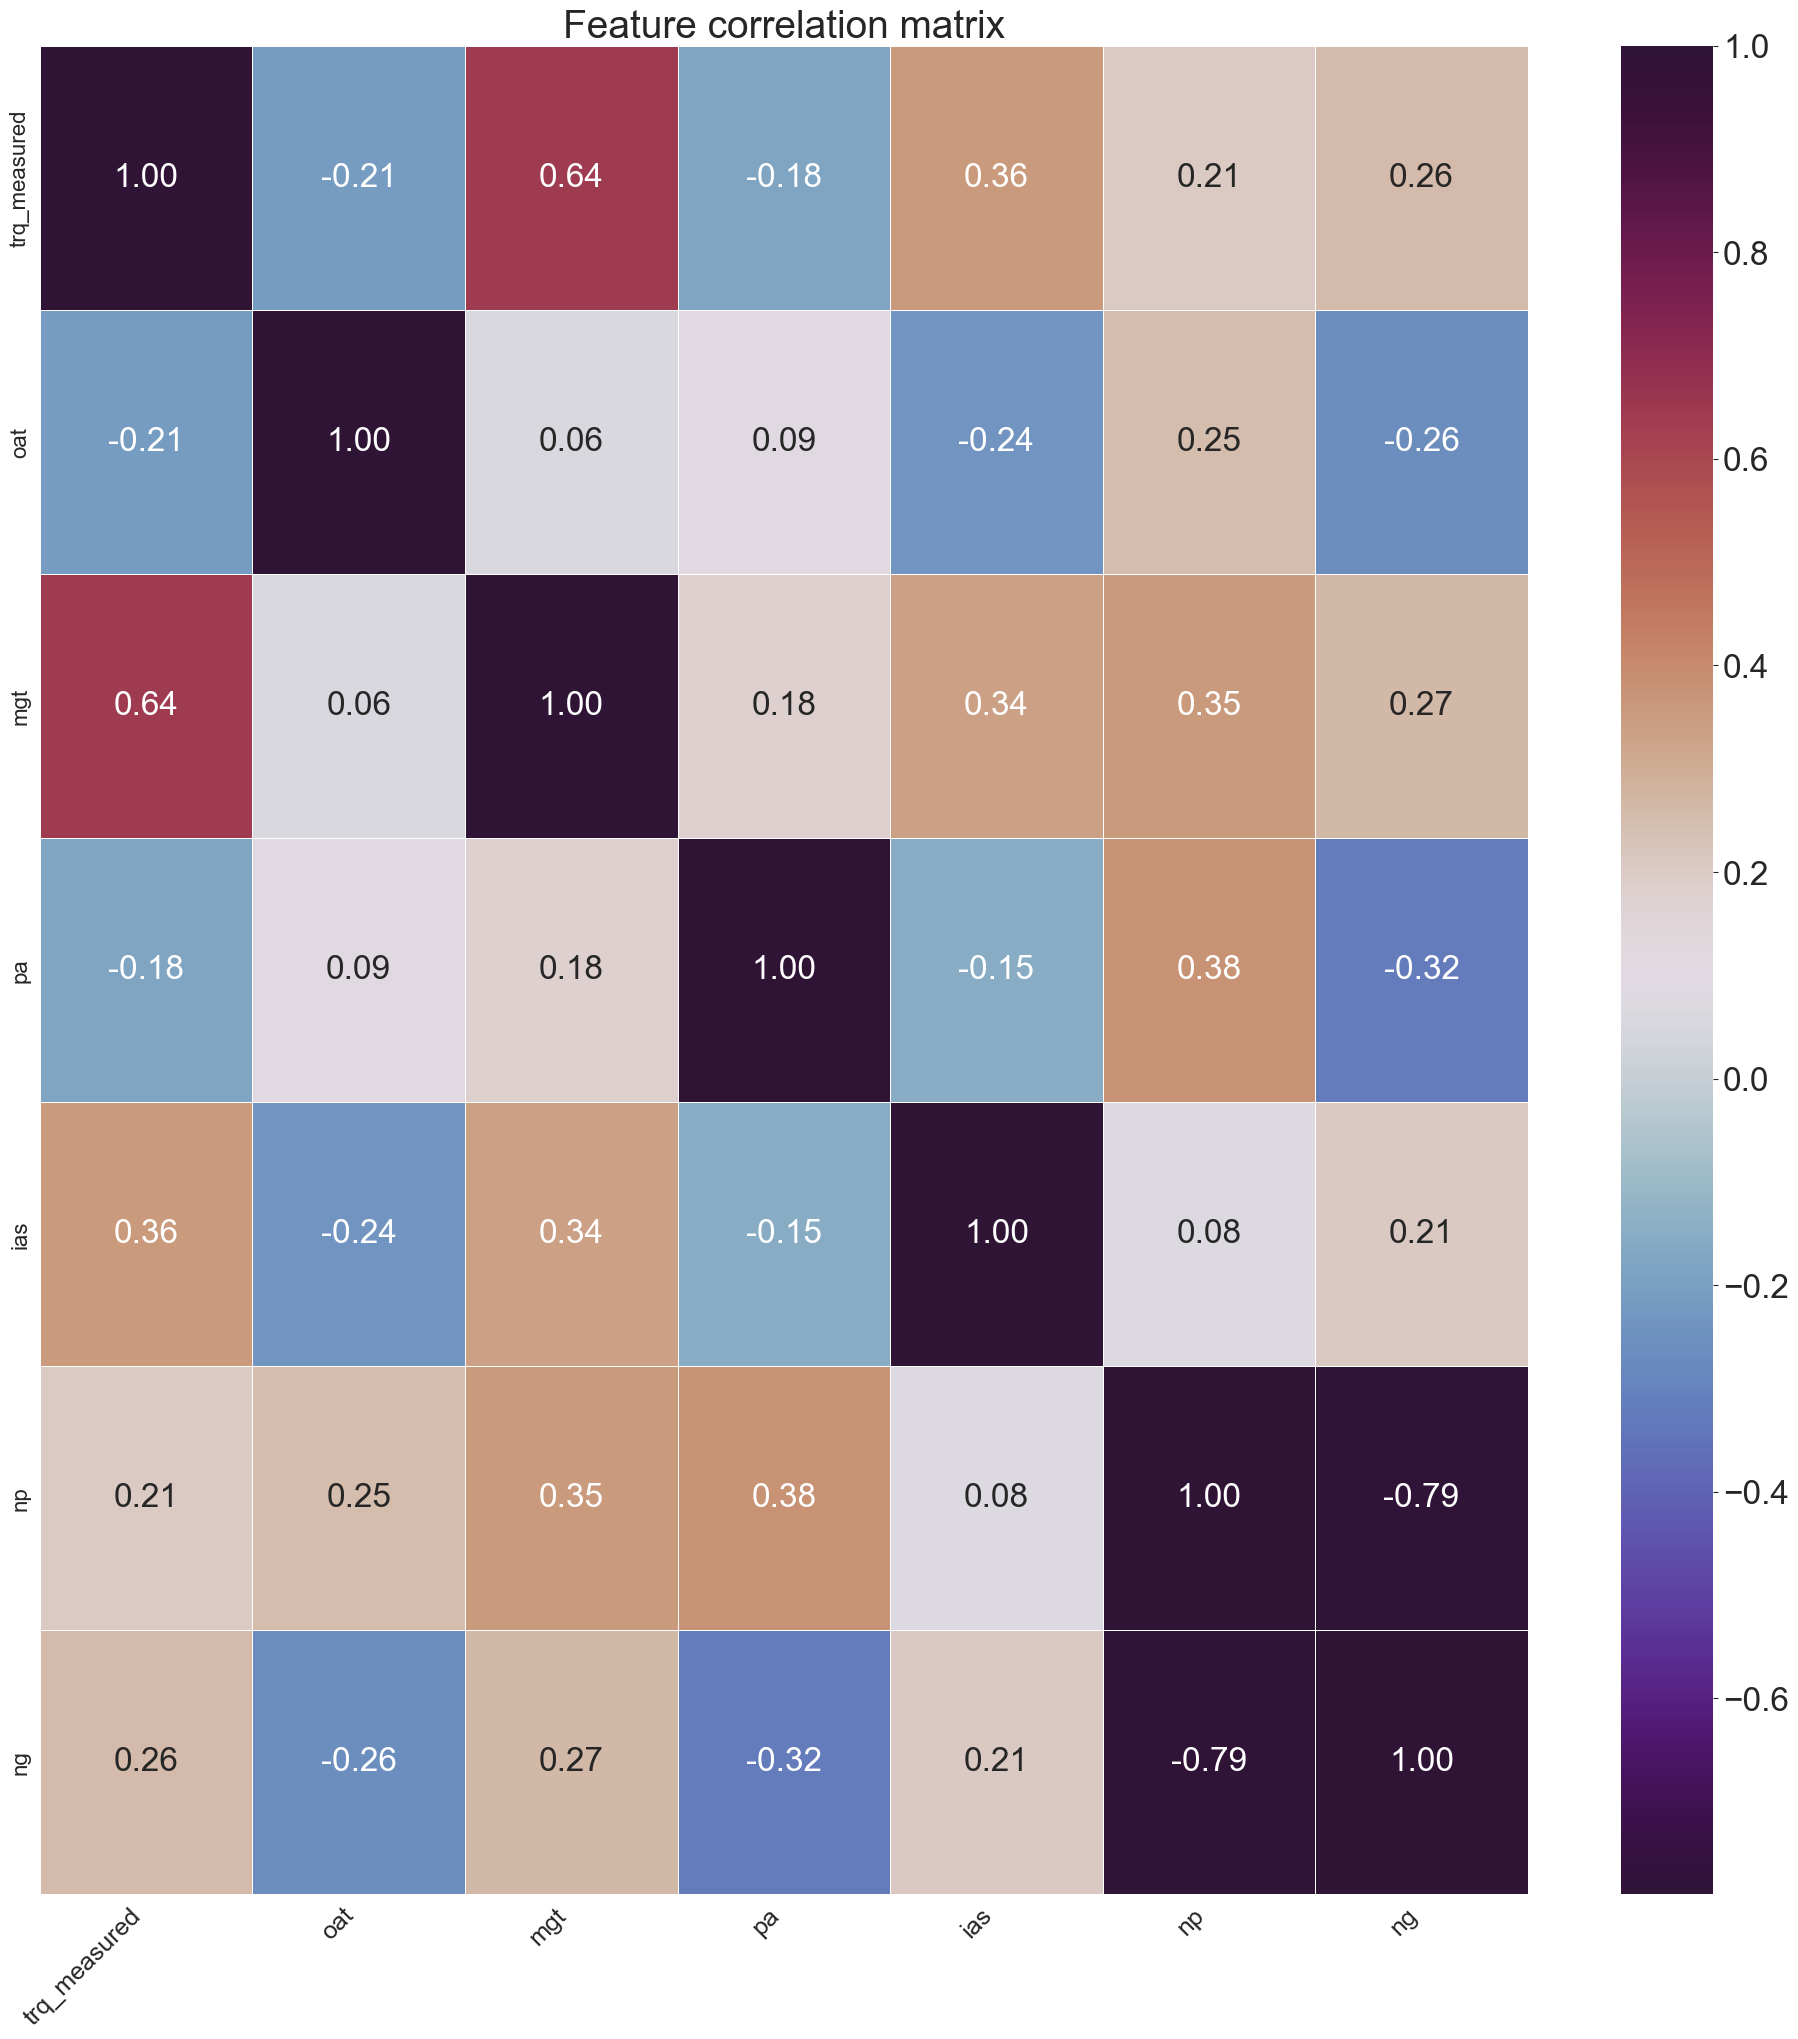

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

### PLOT CORRELATION MATRIX ###
plt.figure(figsize=(24, 24))
corr_matrix = df_x.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="twilight_shifted", linewidths=0.5, cbar=True)

plt.title("Feature correlation matrix", fontsize=28)
plt.xticks(rotation=45, ha="right", fontsize=18)
plt.yticks(fontsize=16)

plt.show()


### PCA

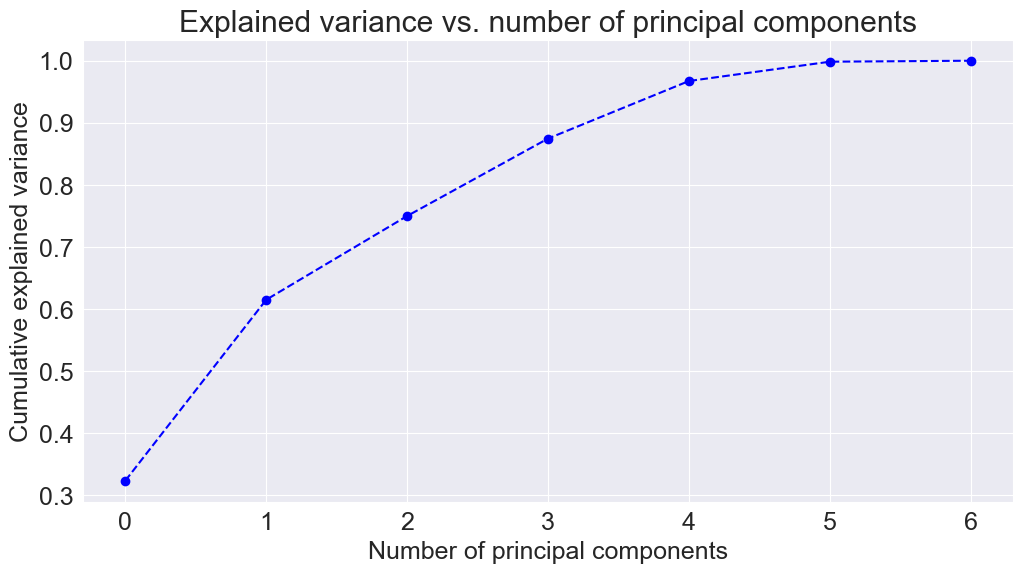

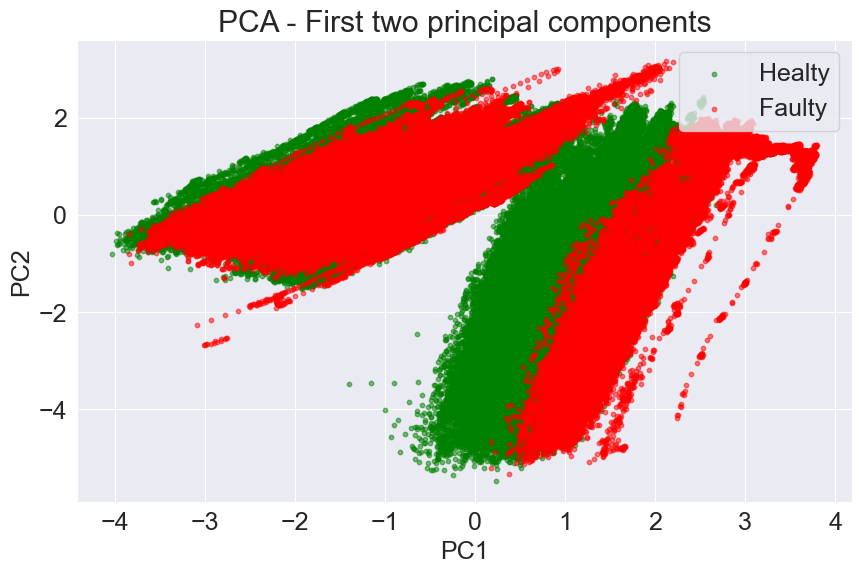

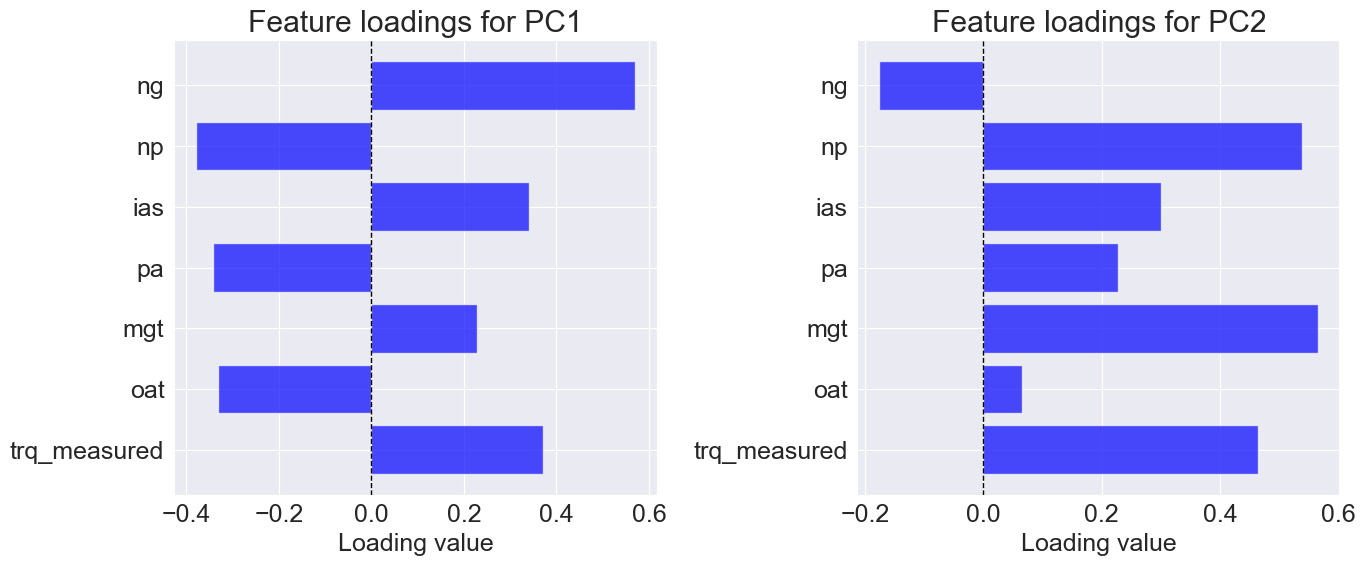

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------------
# 1. Standardize df_x for PCA
# ----------------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_x)

# ----------------------------------------------------------------------
# 2. Apply PCA
# ----------------------------------------------------------------------
pca = PCA(n_components=len(df_x.columns))  # Keep all components initially
X_pca = pca.fit_transform(X_scaled)

# ----------------------------------------------------------------------
# 3. Plot cumulative explained variance
# ----------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs. number of principal components")
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------
# 4. Scatter plot of first two principal components
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
faulty_labels = df_y['faulty'].values  # Get faulty labels from df_y

# Define colors and labels
colors = {0: 'g', 1: 'r'}
labels = {0: 'Healty', 1: 'Faulty'}

# Scatter plot with legend fix
for label in [0, 1]:
    plt.scatter(
        X_pca[faulty_labels == label, 0],  # PC1
        X_pca[faulty_labels == label, 1],  # PC2
        c=colors[label], label=labels[label], alpha=0.5, s=10  # Reduce point size (s) for large datasets
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - First two principal components")
plt.legend(loc="upper right")  # Fix slow legend
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------
# 5. Plot PCA Loadings (Feature Contributions)
# ----------------------------------------------------------------------
loadings = pca.components_[:2]  # Take only PC1 and PC2
features = df_x.columns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for i, pc in enumerate(["PC1", "PC2"]):
    ax[i].barh(features, loadings[i], color='b', alpha=0.7)
    ax[i].set_title(f"Feature loadings for {pc}")
    ax[i].set_xlabel("Loading value")
    ax[i].axvline(0, color='k', linestyle='--', linewidth=1)  # Vertical line at 0 for reference

plt.tight_layout()
plt.show()


# Dataset sampling: skewness study

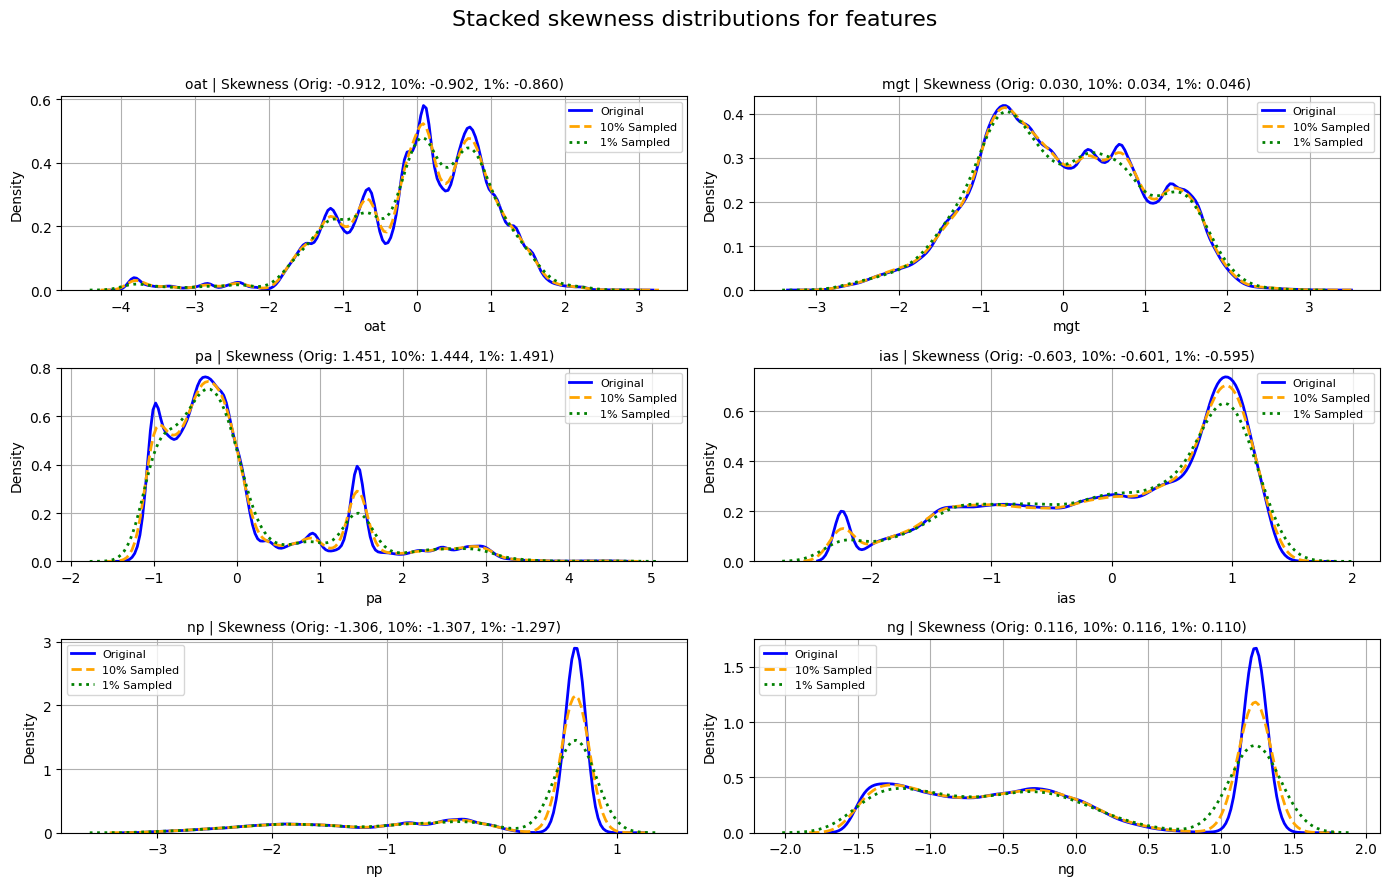

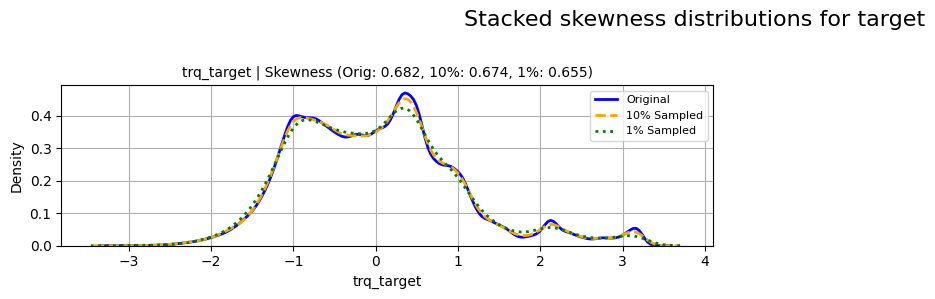

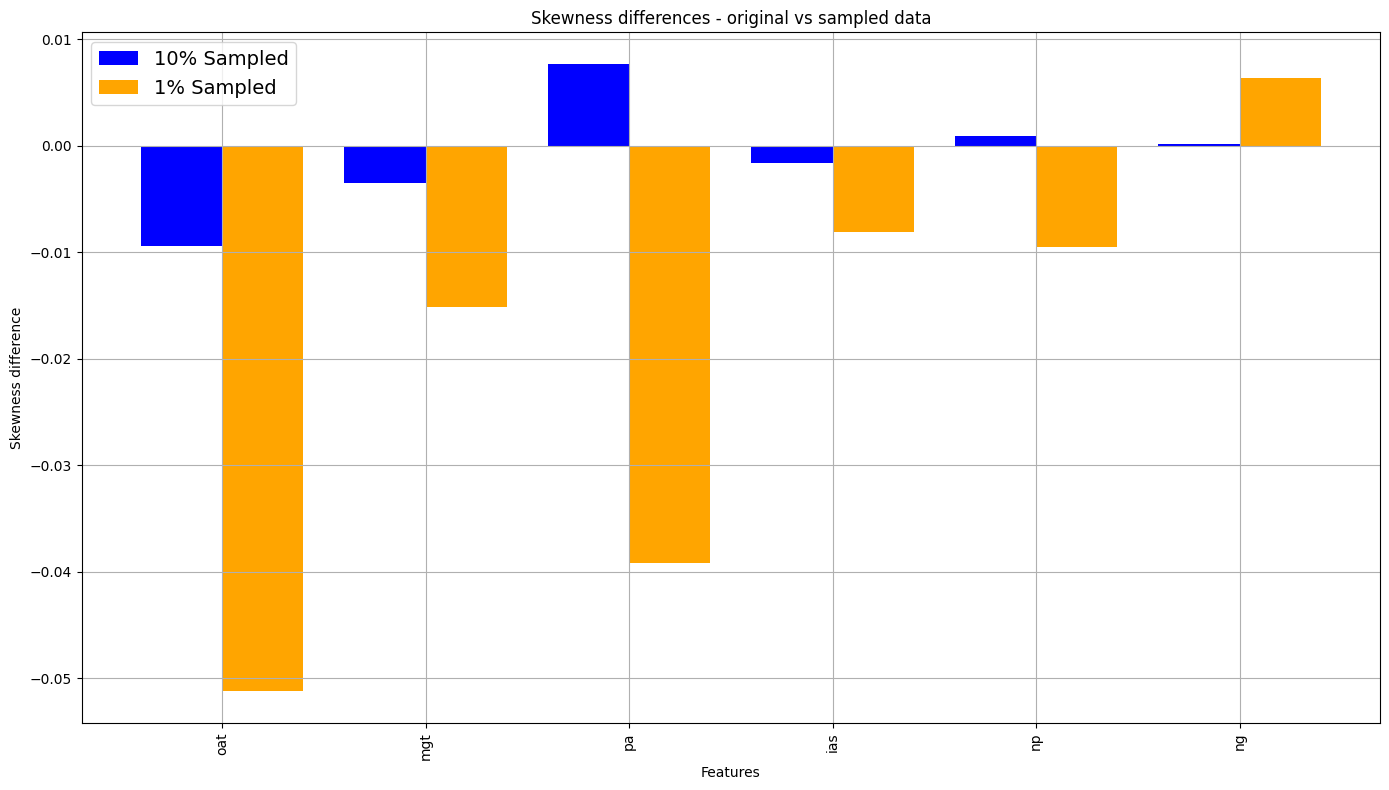

In [9]:
import seaborn as sns
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

df_x = pd.read_csv('../dataset/X_train.csv').drop(columns=['id'])
df_y = pd.read_csv('../dataset/y_train.csv')
df_y['trq_target'] = df_x['trq_measured'] / (df_y['trq_margin'] / 100 + 1)

### NORMALIZE DATA ###
df_x_normalized = (df_x - df_x.mean()) / df_x.std()
df_y_normalized = df_y.copy()
df_y_normalized['trq_target'] = (df_y['trq_target'] - df_y['trq_target'].mean()) / df_y['trq_target'].std()
df_x_normalized.drop(columns=['trq_measured'], inplace=True)

device = "cpu"
train_x_1 = torch.tensor(df_x_normalized.values, dtype=torch.float32, device=device)
train_y_1 = torch.tensor(df_y_normalized[['trq_target', 'faulty']].values, dtype=torch.float32, device=device)
assert train_x_1.shape[0] == train_y_1.shape[0]

### DOWNSAMPLE DATA TO 10% AND 1% OF THE ORIGINAL SIZE ###
np.random.seed(42)
random_indices_10 = np.random.choice(train_x_1.shape[0], size=train_x_1.shape[0] // 10, replace=False)
train_x_10 = train_x_1[random_indices_10].numpy()
train_y_10 = train_y_1[random_indices_10].numpy()
random_indices_100 = np.random.choice(train_x_1.shape[0], size=train_x_1.shape[0] // 100, replace=False)
train_x_100 = train_x_1[random_indices_100].numpy()
train_y_100 = train_y_1[random_indices_100].numpy()

### CONVERT SAMPLED DATA TO DATAFRAMES ###
df_x_10 = pd.DataFrame(train_x_10, columns=df_x_normalized.columns)
df_y_10 = pd.DataFrame(train_y_10, columns=['trq_target', 'faulty'])
df_x_100 = pd.DataFrame(train_x_100, columns=df_x_normalized.columns)
df_y_100 = pd.DataFrame(train_y_100, columns=['trq_target', 'faulty'])

### PLOT SKEWNESS DISTRIBUTIONS ###
def plot_stacked_skewness(df_original, df_sampled_10, df_sampled_100, title):
    num_features = len(df_original.columns)
    rows = (num_features + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 3))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for idx, feature in enumerate(df_original.columns):
        sns.kdeplot(df_original[feature], ax=axes[idx], label="Original", color="blue", linewidth=2)
        sns.kdeplot(df_sampled_10[feature], ax=axes[idx], label="10% Sampled", color="orange", linestyle="dashed", linewidth=2)
        sns.kdeplot(df_sampled_100[feature], ax=axes[idx], label="1% Sampled", color="green", linestyle="dotted", linewidth=2)
        axes[idx].set_title(f"{feature} | Skewness (Orig: {df_original[feature].skew():.3f}, 10%: {df_sampled_10[feature].skew():.3f}, 1%: {df_sampled_100[feature].skew():.3f})", fontsize=10)
        axes[idx].legend(fontsize=8)
        axes[idx].grid()

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot stacked skewness for input features
plot_stacked_skewness(df_x_normalized, df_x_10, df_x_100, "Stacked skewness distributions for features")

# Plot stacked skewness for target variable
plot_stacked_skewness(df_y_normalized[['trq_target']], df_y_10[['trq_target']], df_y_100[['trq_target']], "Stacked skewness distributions for target")

### PLOT SKEWNESS DIFFERENCES ###
skew_diff_10 = df_x_normalized.skew() - df_x_10.skew()
skew_diff_100 = df_x_normalized.skew() - df_x_100.skew()

plt.figure(figsize=(14, 8))
features = df_x_normalized.columns
x = np.arange(len(features))

plt.bar(x - 0.2, skew_diff_10, width=0.4, label="10% Sampled", color='blue')
plt.bar(x + 0.2, skew_diff_100, width=0.4, label="1% Sampled", color='orange')

plt.xlabel("Features")
plt.ylabel("Skewness difference")
plt.title("Skewness differences - original vs sampled data")
plt.xticks(x, features, rotation=90)
plt.legend(fontsize=14)
plt.tight_layout()
plt.grid()
plt.show()


# Feature building

In [14]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

df_x_10 = pd.DataFrame(train_x_10, columns=df_x_normalized.columns)

### CREATE NEW FEATURES ###

# Add Polynomial Features (degree=N includes features up to N°)
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(df_x_10)
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(df_x_10.columns))

# Add NP/NG ratio feature
df_x_10['np_ng_ratio'] = df_x_10['np'] / df_x_10['ng']

# Air density formula: da = 1.2376 * pa + 118.8 * oat - 1782
df_x_10['da'] = (1.2376 * df_x_10['pa']) + (118.8 * df_x_10['oat']) - 1782

# Normalize original features based on air density (da)
for col in df_x_10.columns:
    if col not in ['da']:  # Avoid normalizing air density itself
        df_x_10[f'{col}_norm_da'] = df_x_10[col] / df_x_10['da']

# Concatenate original and new features
df_x_10_builded = pd.concat([df_x_10, poly_df], axis=1)

# Remove duplicate columns
df_x_10_builded = df_x_10_builded.loc[:, ~df_x_10_builded.columns.duplicated()]

# Print description
df_x_10_builded.describe()


,oat,mgt,pa,ias,np,ng,np_ng_ratio,da,oat_norm_da,mgt_norm_da,...,ias^3,ias^2 np,ias^2 ng,ias np^2,ias np ng,ias ng^2,np^3,np^2 ng,np ng^2,ng^3
count,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,...,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000
mean,-0.004710,-0.002197,0.003076,0.000417,-0.000443,-0.000174,0.248104,-1782.555664,-0.000033,-0.000002,...,-0.602588,0.118723,0.000669,-0.350238,0.213432,-0.100648,-1.317659,0.729915,-0.337238,0.115208
std,0.998396,1.001558,0.999820,1.001316,1.002379,0.998953,91.102753,118.724518,0.000539,0.000559,...,2.623519,1.326592,1.349526,1.573700,0.969074,1.138734,4.073986,2.128876,1.373392,1.536363
min,-3.957951,-2.891119,-1.267548,-2.241119,-3.094517,-1.517283,-1340.388184,-2252.272949,-0.002065,-0.002147,...,-11.256282,-15.517435,-7.581808,-21.391682,-3.504015,-5.106820,-29.633192,-3.954202,-6.451974,-3.493011
25%,-0.641596,-0.755174,-0.664085,-0.805538,-0.514902,-0.907072,-1.489863,-1858.696808,-0.000426,-0.000434,...,-0.522708,-0.190376,-0.399104,-0.443773,-0.315838,-0.623589,-0.136513,-0.354315,-0.795343,-0.746320
50%,0.102259,-0.079219,-0.299315,0.262760,0.596009,-0.189069,-0.728237,-1768.095459,-0.000058,0.000044,...,0.018142,0.146987,-0.028344,0.069044,-0.037837,0.015378,0.211718,-0.075052,0.046932,-0.006759
75%,0.722139,0.760414,0.138518,0.884315,0.661062,1.205672,-0.459560,-1696.347900,0.000345,0.000428,...,0.691547,0.630464,0.445660,0.360484,0.506860,0.454977,0.288886,0.336398,0.519884,1.752619
max,2.954227,3.188884,4.591224,1.500573,0.933786,1.467014,12825.647461,-1430.272705,0.001757,0.001622,...,3.378872,4.690047,7.326797,5.835922,9.912276,2.578029,0.814220,13.410119,1.932159,3.157206


### Regression feature selection

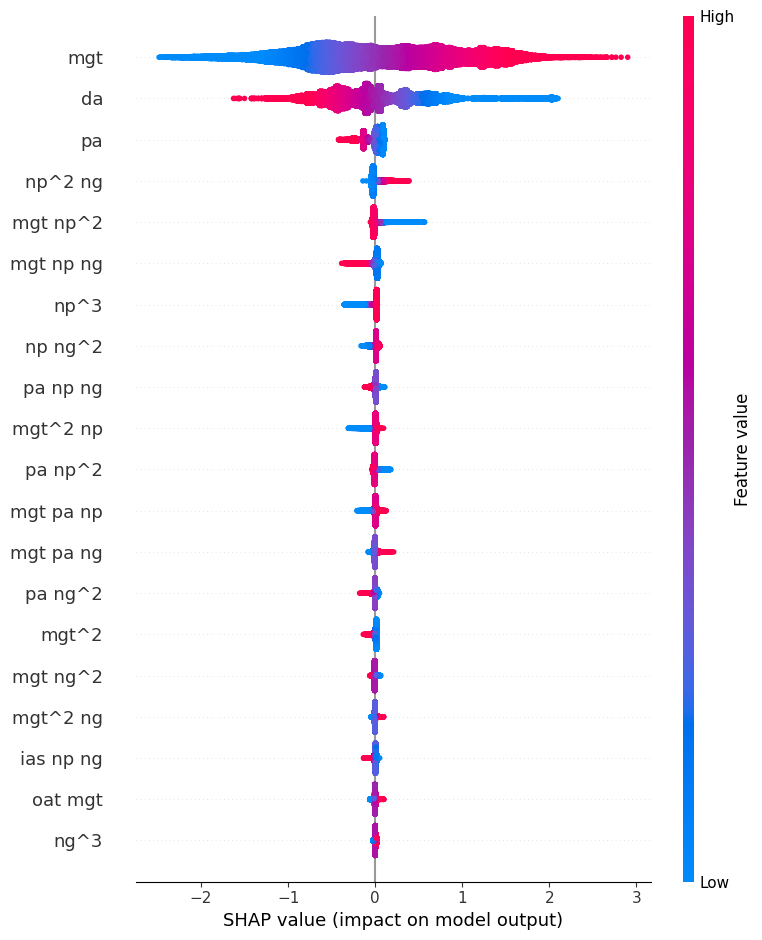

In [20]:
from sklearn.linear_model import LinearRegression
import shap

### FIT A REGRESSION MODEL AND COMPUTE SHAP VALUES ###
model = LinearRegression()
model.fit(df_x_10_builded, df_y_10['trq_target'])
explainer = shap.Explainer(model, df_x_10_builded)
shap_values = explainer(df_x_10_builded)
# Plot SHAP summary with automatic main features selection
shap.summary_plot(shap_values, df_x_10_builded)

In [55]:
import numpy as np

### SELECT TOP N FEATURES BASED ON SHAP VALUES ###
n = 25

# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Get the indices of the top 50 most important features
top_n_indices = np.argsort(shap_importance)[-n:]

# Get the corresponding feature names
top_n_features = df_x_10_builded.columns[top_n_indices]

# Create a new DataFrame with only the top 50 features
df_x_reg_top = df_x_10_builded[top_n_features].copy()

# Print summary of selected features
print(f"Top {n} selected features:\n{top_n_features.tolist()}")


Top 25 selected features:
['pa^2', 'mgt ias np', 'ias np^2', 'mgt ias ng', 'ias ng^2', 'ng^3', 'oat mgt', 'ias np ng', 'mgt^2 ng', 'mgt ng^2', 'mgt^2', 'pa ng^2', 'mgt pa ng', 'mgt pa np', 'pa np^2', 'mgt^2 np', 'pa np ng', 'np ng^2', 'np^3', 'mgt np ng', 'mgt np^2', 'np^2 ng', 'pa', 'da', 'mgt']


In [56]:
### EXPORT PREPROCESSED DATASET FOR REGRESSION TO CSV ###

import os

# Ensure folder exists
os.makedirs('../dataset/regression', exist_ok=True)

# Export df_x_10_regression and df_y_10 as CSV in the '../dataset/' folder
df_x_reg_top.to_csv('../dataset/regression/X_train_reg_top.csv', index=False)
df_y_10.to_csv('../dataset/regression/y_train_10.csv', index=False)

### Classification feature selection

Select only top N most discriminant features: the code calculates the absolute difference (abs_diff) between the mean feature values for the healthy and faulty groups.

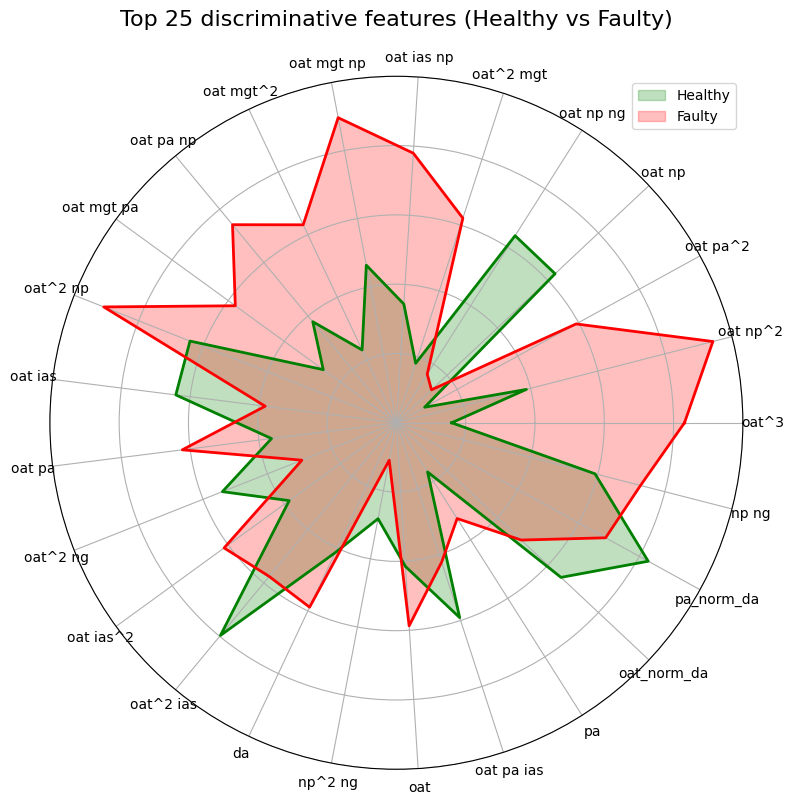

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### RADAR CHART FOR TOP N MOST DISCRIMINATIVE FEATURES ###

# ----------------------------------------------------------------------
# 1. Merge df_x (features) and df_y (labels) if necessary
# ----------------------------------------------------------------------
train_data = pd.concat([df_x_10_builded, df_y_10], axis=1)

# Remove the 'id' column if present
if 'id' in train_data.columns:
    train_data = train_data.drop(['id'], axis=1)

# ----------------------------------------------------------------------
# 2. Remove 'trq_target' from the dataset
# ----------------------------------------------------------------------
if 'trq_target' in train_data.columns:
    train_data = train_data.drop(['trq_target'], axis=1)

# ----------------------------------------------------------------------
# 3. Split data into healthy (faulty == 0) and faulty (faulty == 1) subsets
# ----------------------------------------------------------------------
X_train_healthy = train_data[train_data['faulty'] == 0].drop('faulty', axis=1)
X_train_faulty = train_data[train_data['faulty'] == 1].drop('faulty', axis=1)

# ----------------------------------------------------------------------
# 4. Min-Max scaling: Normalize all features between 0 and 1
# ----------------------------------------------------------------------
def min_max_scale(df):
    return (df - df.min()) / (df.max() - df.min())

X_train_healthy_scaled = min_max_scale(X_train_healthy)
X_train_faulty_scaled = min_max_scale(X_train_faulty)

# Compute the mean value of each feature for both groups
mean_features_healthy = X_train_healthy_scaled.mean()
mean_features_faulty = X_train_faulty_scaled.mean()

# Calculate the absolute difference between the mean values of healthy and faulty states
abs_diff = np.abs(mean_features_healthy - mean_features_faulty)

# ----------------------------------------------------------------------
# 5. Select the top N most discriminative features based on the absolute difference
# ----------------------------------------------------------------------
n = 25
top_n_features = abs_diff.nlargest(n).index

# Get the corresponding values for the top 25 features
values_healthy_top_n = mean_features_healthy[top_n_features].values
values_faulty_top_n = mean_features_faulty[top_n_features].values

# Prepare the labels and values for radar chart
labels = top_n_features
values_healthy_top_n = np.concatenate((values_healthy_top_n, [values_healthy_top_n[0]]))
values_faulty_top_n = np.concatenate((values_faulty_top_n, [values_faulty_top_n[0]]))

# Compute angles for the radar chart
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# ----------------------------------------------------------------------
# 6. Adjust figure size dynamically based on the number of features
# ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(min(2 * num_vars, 18), min(2 * num_vars, 9)), subplot_kw=dict(polar=True))

# Radar chart for healthy state
ax.fill(angles, values_healthy_top_n, color='g', alpha=0.25, label='Healthy')
ax.plot(angles, values_healthy_top_n, color='g', linewidth=2)

# Radar chart for faulty state
ax.fill(angles, values_faulty_top_n, color='r', alpha=0.25, label='Faulty')
ax.plot(angles, values_faulty_top_n, color='r', linewidth=2)

# Remove y-ticks and set the labels for x-ticks
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)

# Set title and limits
ax.set_title(f"Top {n} discriminative features (Healthy vs Faulty)", size=16, pad=18)
ax.set_ylim(0, 1)  # Keep scale between 0 and 1

# Add legend
ax.legend(loc='upper right')

plt.show()

# ----------------------------------------------------------------------
# 7. EXPORT TOP N FEATURES (FULL COLUMNS) TO CSV
# ----------------------------------------------------------------------

# Select the top N features columns from the original dataset
top_n_healthy_features = X_train_healthy[top_n_features]
top_n_faulty_features = X_train_faulty[top_n_features]

# Concatenate the selected columns (healthy and faulty)
top_n_full_columns = pd.concat([top_n_healthy_features, top_n_faulty_features], axis=1)

# Ensure folder exists for saving the dataset
os.makedirs('../dataset/classification', exist_ok=True)

# Export the DataFrame to a CSV file
top_n_full_columns.to_csv('../dataset/classification/X_train_class_top.csv', index=False)
df_y_10.to_csv('../dataset/classification/y_train_10.csv', index=False)
